# Assignment2 -Group: 33
Tutors:  

 - Dongang Wang
 
Group members:

- Shengyuan Sun 460257820
- Rui Chen 470111585

---

## Methods

### Connect PyDrive

Run the code below and follow the instruction to get the authentication from google drive.

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Load dataset
The dataset we use is **SVHN**. SVHN provides two formats of train and test data. We choose format 2 as the input of our data source.
The dataset has been shared in a drive directory with its **id = 1rcC3ZHrYF9jLAZwRx-XnQg7d-Hgp3OYf**
 - Input : ID of dataset directory
 - Output: Two objects of  files ("train_set" and "test_set")

In [2]:
# List the files in the shared directory
files = drive.ListFile({'q': "'1rcC3ZHrYF9jLAZwRx-XnQg7d-Hgp3OYf' in parents and trashed=false"}).GetList()
for file in files:
    print('File_name: %s, File_id: %s' % (file['title'], file['id']))

File_name: test_32x32.mat, File_id: 1u6CD2TBjcbnBRGFx2ovaMbxi9LfjQ-Df
File_name: train_32x32.mat, File_id: 1gYfvRD9LHbleNNebLHkUE4S2N7NoBzcs


In [0]:
# Copy the data files to Colab VM
fetch_test_file = drive.CreateFile({'id': '1u6CD2TBjcbnBRGFx2ovaMbxi9LfjQ-Df'})
fetch_test_file.GetContentFile('test_32x32.mat')
fetch_train_file = drive.CreateFile({"id":"1gYfvRD9LHbleNNebLHkUE4S2N7NoBzcs"})
fetch_train_file.GetContentFile("train_32x32.mat")

In [4]:
# Display the files in Colab VM
ls

datalab/  log_cnn0/  log_pca_nn/  modelfor_0/  test_32x32.mat  train_32x32.mat


In [0]:
# Load the files
from scipy.io import loadmat as load
train_set = load("train_32x32.mat")
test_set = load("test_32x32")

In [0]:
# !top
# gc.collect()
# !free -m
# !kill -9 118

### Import modules

In [0]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression   
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.metrics import classification_report, confusion_matrix
import gc
import time


### Preprocessing

In [0]:
def im2gray(image):
    # convert RGB to Gray image
    image = image.astype(float)

    image_gray = np.dot(image, [[0.2989],[0.5870],[0.1140]])
    return image_gray

def format_data(pca_component = 50):
    # Format the training and testing set
    train_X = train_set["X"].transpose((3,0,1,2))
    train_y = train_set["y"]
    test_X = test_set["X"].transpose((3,0,1,2))
    test_y = test_set["y"]
    
    # graying image
    train_X = im2gray(train_X)
    test_X = im2gray(test_X)

    # Flat features to one vectors
    temp = []
    for i in train_X:
        temp.append(i.flatten())
    train_X = None
    gc.collect()
    train_X = np.array(temp, dtype="float")
    train_y = np.ravel(train_y)

    temp = []
    for i in test_X:
        temp.append(i.flatten())
    test_X = None
    gc.collect()
    test_X = np.array(temp, dtype="float")
    test_y = np.ravel(test_y)
    # Normalization
    scaler = StandardScaler()
    scaler.fit(train_X)
    train_X = scaler.transform(train_X)
    test_X = scaler.transform(test_X)

    print("train_X shape: " + str(train_X.shape))
    print("train_y shape: " + str(train_y.shape))
    print("test_X shape: " + str(test_X.shape))
    print("test_y shape: " + str(test_y.shape))
    
    # PCA dimensionality reduction
    
    if pca_component > 0:
        pca = PCA(n_components=pca_component)
        pca.fit(train_X)
        train_X = pca.transform(train_X)
        test_X = pca.transform(test_X)
        print("After PCA train_X shape: " + str(train_X.shape))
        print("After PCA train_y shape: " + str(train_y.shape))
        print("After PCA test_X shape: " + str(test_X.shape))
        print("After PCA test_y shape: " + str(test_y.shape))
        
    return train_X,train_y,test_X,test_y

start = time.time()
train_X,train_y,test_X,test_y = format_data()
end = time.time()
print("time consumption: " + str(end-start))
gc.collect()

train_X shape: (73257, 1024)
train_y shape: (73257,)
test_X shape: (26032, 1024)
test_y shape: (26032,)
After PCA train_X shape: (73257, 50)
After PCA train_y shape: (73257,)
After PCA test_X shape: (26032, 50)
After PCA test_y shape: (26032,)
time consumption: 23.143392324447632


0

In [0]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

gnb = GaussianNB()
gnb.fit(train_X, train_y)

bnb = BernoulliNB()
bnb.fit(train_X, train_y)

sgd = SGDClassifier(loss="hinge", penalty="l2",alpha=0.001, shuffle=True, verbose=0,\
                    n_jobs=4, random_state=None, learning_rate='optimal')
sgd.fit(train_X, train_y)

knn = KNeighborsClassifier(n_neighbors=2, algorithm='ball_tree')
knn.fit(train_X, train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [0]:
from sklearn.metrics import accuracy_score
print("GaussianNB "+str(accuracy_score(test_y,gnb.predict(test_X))))
print("BernoulliNB "+str(accuracy_score(test_y,bnb.predict(test_X))))
print("SGDClassifier "+str(accuracy_score(test_y,sgd.predict(test_X))))
print("NearestNeighbors "+str(accuracy_score(test_y,knn.predict(test_X))))


GaussianNB 0.12484634296250768
BernoulliNB 0.1066379840196681
SGDClassifier 0.20885832821143208


### Method1 ---SGD

#### Build GridSearchCV for SGDClassifer

In [0]:
pipe = Pipeline([('classifier',SGDClassifier(alpha=0.001, shuffle=True, verbose=0,\
                    n_jobs=4, random_state=None, learning_rate='optimal'))])
# set turing parameter
LOSS_FUNCTION = ["hinge", "log"]
PENALTY = ["l2","l1"]
param_grid = [
    {
        "classifier__loss":LOSS_FUNCTION,
        "classifier__penalty":PENALTY
    }
]
start= time.time()

grid = GridSearchCV(pipe, cv=10, param_grid=param_grid, n_jobs=1,scoring="accuracy")
grid.fit(train_X, train_y)

# persist sgd grid 
joblib.dump(grid,"sgd_grid.dmp")
end = time.time()
print("Time consumption: " + str(end-start))
gc.collect()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/s

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/s

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/s

Time consumption: 56.16012382507324


198

In [0]:
grid.best_estimator_

Pipeline(memory=None,
     steps=[('classifier', SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=4, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))])

The grid resuslt shows the best turing parameters of SGD classifier in this case are loss="log" and penalty = "l1"

####machine learning techniques

In [0]:
# Training entire train set and get the SGD model
clf = SGDClassifier(loss='log', penalty='l1', alpha=0.001, shuffle=True, verbose=0,\
                    n_jobs=4, random_state=None, learning_rate='optimal')
clf.fit(train_X, train_y)

# Predict test label
prediction = clf.predict(test_X)

print("Accuracy:\n", accuracy_score(test_y, prediction))
print('Classification report:\n', classification_report(test_y, prediction))
print('Confusion Matrix:\n', confusion_matrix(test_y, prediction))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Accuacy:
 0.19214812538414258
Classification report:
              precision    recall  f1-score   support

          1       0.21      0.64      0.32      5099
          2       0.18      0.23      0.20      4149
          3       0.12      0.13      0.12      2882
          4       0.29      0.05      0.09      2523
          5       0.23      0.03      0.05      2384
          6       0.17      0.02      0.03      1977
          7       0.10      0.02      0.03      2019
          8       0.13      0.02      0.03      1660
          9       0.13      0.03      0.05      1595
         10       0.20      0.05      0.08      1744

avg / total       0.18      0.19      0.14     26032

Confusion Matrix:
 [[3258 1065  547   53   42   20   42   10   26   36]
 [2218  938  625   67   40   31   81   32   65   52]
 [1818  453  361   38   37   14   47   15   63   36]
 [1412  460  259  131   31   30   43   18   27  112]
 [1420  349  326   55   73   12   25   17   77   30]
 [1175  409  210   36  

###Method2---Random Forest

#### Build GridSearchCV for Random Forest Classifer

In [0]:
# set turing parameter
param_grid = [
    {
   
#         "min_samples_leaf":range(10,60,20),
#         'max_depth':range(3,10,2), 
        'min_samples_split':range(40,100,20),
    }
]

start= time.time()
grid = GridSearchCV(RandomForestClassifier(n_estimators=20,max_depth=9,\
             min_samples_leaf=30,max_features='sqrt' ,oob_score=True,random_state=10), \
             cv=10, param_grid=param_grid, n_jobs=1,scoring="accuracy")
grid.fit(train_X, train_y)

# persist sgd grid 
joblib.dump(grid,"rdf_grid.dmp")
end = time.time()
print("Time consumption: " + str(end-start))
gc.collect()

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees we

Time consumption: 285.4042341709137


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


452

In [0]:
grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=30, min_samples_split=40,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=True, random_state=10, verbose=0, warm_start=False)

In [0]:
grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=30, min_samples_split=40,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=True, random_state=10, verbose=0, warm_start=False)

In [0]:
grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=30, min_samples_split=40,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=True, random_state=10, verbose=0, warm_start=False)

####machine learning techniques

In [0]:
clf = RandomForestClassifier(n_estimators=200,max_depth=200,min_samples_split=80,\
             min_samples_leaf=10,max_features='sqrt' ,oob_score=True,random_state=10) 
clf.fit(train_X, train_y)

# Predict test label
prediction = clf.predict(test_X)

print("Accuracy:\n", accuracy_score(test_y, prediction))
print('Classification report:\n', classification_report(test_y, prediction))
print('Confusion Matrix:\n', confusion_matrix(test_y, prediction))



Accuracy:
 0.5684542102028273
Classification report:
              precision    recall  f1-score   support

          1       0.45      0.93      0.61      5099
          2       0.53      0.77      0.63      4149
          3       0.59      0.39      0.47      2882
          4       0.65      0.66      0.66      2523
          5       0.75      0.45      0.56      2384
          6       0.80      0.28      0.41      1977
          7       0.81      0.46      0.59      2019
          8       0.93      0.18      0.30      1660
          9       0.82      0.38      0.52      1595
         10       0.83      0.37      0.51      1744

avg / total       0.66      0.57      0.55     26032

Confusion Matrix:
 [[4719  212   29   84    9    3   35    0    3    5]
 [ 699 3189   71  115   20    3   44    2    6    0]
 [1032  464 1120   87   89    0   52    4   25    9]
 [ 569  217   36 1665    9    5    6    0    9    7]
 [ 635  299  235   91 1064   21    6    2   23    8]
 [ 602  272   89  241  

Make adjustments to the maximum number of features max_features

The final model fits

###Method3---Logistic Regression

#### Train Logistic Regression Model

In [0]:
start= time.time()
grid = GridSearchCV(LogisticRegression(),\
             cv=10, param_grid={},n_jobs=1,scoring="accuracy")
grid.fit(train_X, train_y)

# persist sgd grid 
joblib.dump(grid,"lgr_grid.dmp")
end = time.time()
print("Time consumption: " + str(end-start))
gc.collect()

Time consumption: 314.67367339134216


421

####machine learning

In [0]:
# grid predict
prediction = grid.predict(test_X)

print("Accuracy:\n", accuracy_score(test_y, prediction))
print('Classification report:\n', classification_report(test_y, prediction))
print('Confusion Matrix:\n', confusion_matrix(test_y, prediction))

Accuacy:
 0.22483866011063305
Classification report:
              precision    recall  f1-score   support

          1       0.22      0.77      0.35      5099
          2       0.21      0.27      0.24      4149
          3       0.20      0.08      0.11      2882
          4       0.33      0.10      0.15      2523
          5       0.27      0.08      0.13      2384
          6       0.26      0.02      0.04      1977
          7       0.13      0.01      0.02      2019
          8       0.24      0.01      0.03      1660
          9       0.38      0.01      0.02      1595
         10       0.33      0.04      0.07      1744

avg / total       0.25      0.22      0.16     26032

Confusion Matrix:
 [[3906  946   38   85   67    9   25    4    1   18]
 [2556 1115  238   93   76   24   24    6    3   14]
 [2001  487  220   59   68    8   19    5    3   12]
 [1570  443  127  248   62   12   15    3    4   39]
 [1548  345  188   64  198   12    8    8    7    6]
 [1347  369   54   57  

### Method4---Neuro network

####preprocessing

In [0]:
from __future__ import print_function
from sklearn.preprocessing import OneHotEncoder
import scipy.io as scio
from sklearn.decomposition import PCA
import numpy as np
import time
import gc

In [8]:
train_path = "train_32x32.mat"
data = scio.loadmat(train_path)
train_X = data["X"]
train_y = data["y"]
train_X = train_X.T
tmp = []
for row in train_X:
    tmp.append(row.flatten())
train_X = None
gc.collect()
train_X = np.array(tmp)
tmp = None
train_X = train_X - train_X.mean(axis=0)
train_X.shape
d = 50
pca = PCA(n_components=d)
start = time.time()
train_X = pca.fit(train_X).transform(train_X)

dataset = np.hstack((train_X,train_y))

enc = OneHotEncoder().fit(train_y.reshape(-1, 1))
train_y = enc.transform(train_y.reshape(-1, 1)).toarray()

print("training_data_shape=", train_X.shape)
print("training_labels_shape",train_y.shape)
end = time.time()
print("time consumption of preprocess : {}s".format(end-start))

training_data_shape= (73257, 50)
training_labels_shape (73257, 10)
time consumption of preprocess : 31.653689861297607s


####machine learning technique

In [0]:
import tensorflow as tf

Attach a lot of summaries to a Tensor

In [0]:
def variable_summaries(var):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

helper function

In [0]:
def fc_weight_variable(layer_name, shape):
    return tf.get_variable(layer_name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(shape):
    return tf.Variable(tf.constant(0.0, shape=shape))

def fc_layer(input,
             layer_name,
             num_inputs,
             num_outputs,
             relu=True):
    with tf.name_scope(layer_name):
        with tf.name_scope('weights'):
            weights = fc_weight_variable(layer_name, shape=[num_inputs, num_outputs])
            variable_summaries(weights)
        with tf.name_scope('biases'):
            biases = bias_variable(shape=[num_outputs])
            variable_summaries(biases)
        with tf.name_scope('Wx_plus_b'):
            layer = tf.matmul(input, weights) + biases
            tf.summary.histogram('pre_activations', layer)
        if relu:
            layer = tf.nn.relu(layer)
            tf.summary.histogram('activations', layer)
    return layer


neural network parameters

In [0]:
fc_size = 500
class_num = 10
batch_size = 64

training function

In [0]:
def train(train_data,train_labels,test_data,test_labels):
    data_size = len(train_data)
    tf.reset_default_graph()

    with tf.name_scope('input'):
        x = tf.placeholder(tf.float32, shape=[None, 50], name='x')
        y_ = tf.placeholder(tf.float32, shape=[None, class_num], name='y_')
        keep_prob = tf.placeholder(tf.float32)


    y_true_cls = tf.argmax(y_, dimension=1)

    fc_1 = fc_layer(input=x,
                    layer_name="fc_1",
                    num_inputs=50,
                    num_outputs=fc_size,
                    relu=True)

    fc_1
    #
    fc_2 = fc_layer(input=fc_1,
                    layer_name="fc_2",
                    num_inputs=fc_size,
                    num_outputs=class_num,
                    relu=False)

    fc_2

    y = tf.nn.softmax(fc_2)
    y_pred_cls = tf.argmax(y, dimension=1)

    with tf.name_scope('cross_entropy'):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc_2, labels=y_)
        cost = tf.reduce_mean(cross_entropy)
    tf.summary.scalar('cross_entropy', cost)

    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(0.001).minimize(cost)

    with tf.name_scope('accuracy'):
        with tf.name_scope('correct_prediction'):
            correct_prediction = tf.equal(y_pred_cls, y_true_cls)
        with tf.name_scope('accuracy'):
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy)

    with tf.Session()as sess:
        merged = tf.summary.merge_all()
        train_writer = tf.summary.FileWriter('./log_pca_nn' + '/train',
                                             sess.graph)
        test_writer = tf.summary.FileWriter('./log_pca_nn' + '/test')

        init_op=tf.initialize_all_variables()
        sess.run(init_op)
        step =5000

        for i in range(step):
            start = (i *batch_size) % data_size
            end = min(start+batch_size,data_size)
            summary,_ =sess.run([merged,train_step],feed_dict={x:train_data[start:end],y_:train_labels[start:end]})
            train_writer.add_summary(summary, i)

            if i%100==0:
                total_cross_entropy = sess.run(cross_entropy, feed_dict={x:train_data,y_:train_labels})

                print(" total_cross_entropy",total_cross_entropy)

        summary, test_accuracy = sess.run([merged,accuracy], {x:test_data, y_: test_labels, keep_prob: 1.0})
        test_writer.add_summary(summary, i)
        test_pred = sess.run(y_pred_cls, {x:test_data, y_: test_labels, keep_prob: 1.0})
    print(" test_accuracy", test_accuracy)

    return test_pred

k-flod cross validation function

In [0]:
def train_test_split_10(train_X, train_y, k):
    num_of_examples = len(train_X)
    start_jump = (num_of_examples // 10) * k
    end_jump = (num_of_examples // 10) * (k + 1)
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for i in range(len(train_X)):
        if i <= start_jump:
            X_train.append(train_X[i])
            y_train.append(train_y[i])
        elif i > end_jump:
            X_train.append(train_X[i])
            y_train.append(train_y[i])
        else:
            X_test.append(train_X[i])
            y_test.append(train_y[i])

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    return X_train,  y_train,X_test, y_test

print function

In [0]:
import matplotlib.pyplot as plt
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    """ Plot nrows * ncols images from images and annotate the images
    """
    # Initialize the subplotgrid
    fig, axes = plt.subplots(nrows, ncols)

    # Randomly select nrows * ncols images
    rs = np.random.choice(images.shape[0], nrows * ncols)

    # For every axes object in the grid
    for i, ax in zip(rs, axes.flat):

        # Predictions are not passed
        if cls_pred is None:
            if np.argmax(cls_true[i]) + 1 == 10:
                title = "True: {0}".format(0)
            else:
                title = "True: {0}".format(np.argmax(cls_true[i]) + 1)

        # When predictions are passed, display labels + predictions
        else:
            if np.argmax(cls_true[i]) + 1 == 10:
                if cls_pred[i] + 1 == 10:
                    title = "True: {0}, Pred: {1}".format(0, 0)
                else:
                    title = "True: {0}, Pred: {1}".format(0, cls_pred[i] + 1)
            else:
                title = "True: {0}, Pred: {1}".format(np.argmax(cls_true[i]) + 1, cls_pred[i] + 1)
                if cls_pred[i] + 1 == 10:
                    title = "True: {0}, Pred: {1}".format(np.argmax(cls_true[i]) + 1, 0)
                else:
                    title = "True: {0}, Pred: {1}".format(np.argmax(cls_true[i]) + 1, cls_pred[i] + 1)

            # Display the image
        ax.imshow(images[i, :, :, 0], cmap='binary')

        # Annotate the image
        ax.set_title(title)

        # Do not overlay a grid
        ax.set_xticks([])
        ax.set_yticks([])

analysis function

In [0]:
import seaborn as sns
from sklearn.metrics import  confusion_matrix
def analysis(test_pred, test_labels, test_data_img):
    incorrect = test_pred != np.argmax(test_labels, axis=1)
    print(test_pred)
    temp = test_data_img

    # Select the incorrectly classified examples
    images = temp[incorrect]
    cls_true = test_labels[incorrect]
    cls_pred = test_pred[incorrect]

    # Plot the mis-classified examples
    plot_images(images, 3, 6, cls_true, cls_pred)

    correct = np.invert(incorrect)

    # Select the correctly classified examples
    images = temp[correct]
    cls_true = test_labels[correct]
    cls_pred = test_pred[correct]

    # Plot the mis-classified examples
    plot_images(images, 3, 6, cls_true, cls_pred)

    plt.figure(figsize=(12, 8))

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true=np.argmax(test_labels, axis=1), y_pred=test_pred)

    # Normalize the confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0

    # Visualize the confusion matrix
    sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True)
    plt.show()

training

 total_cross_entropy [202.79156 252.44865 196.95816 ... 179.95149 156.82849  97.68421]
 total_cross_entropy [18.275599 12.642467 22.122456 ...  4.558236 60.70642  99.83128 ]
 total_cross_entropy [ 6.1284637   7.3652115   0.37913775 ...  0.          0.
 74.33432   ]
 total_cross_entropy [0.0000000e+00 0.0000000e+00 7.1525551e-07 ... 0.0000000e+00 4.4360566e-03
 3.7604385e+01]
 total_cross_entropy [7.6408920e+00 1.2486527e-03 0.0000000e+00 ... 0.0000000e+00 0.0000000e+00
 5.8815399e+01]
 total_cross_entropy [3.0027863e-02 2.0662590e+01 0.0000000e+00 ... 0.0000000e+00 0.0000000e+00
 3.3788788e+01]
 total_cross_entropy [5.8693346e-04 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00 2.0117279e+01
 1.1274614e+01]
 total_cross_entropy [ 0.        20.191414   0.        ...  0.         1.5636348 43.48581  ]
 total_cross_entropy [3.0339303e+00 1.7881378e-06 0.0000000e+00 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
 total_cross_entropy [ 6.204448  0.        0.       ...  0.       15.235657 61.16

 total_cross_entropy [0.0000000e+00 0.0000000e+00 1.1920922e-06 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
 total_cross_entropy [0.        0.        0.        ... 0.        1.553192  1.7534046]
 total_cross_entropy [9.6197269e-05 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00 0.0000000e+00
 1.6905731e+00]
 total_cross_entropy [0.00129389 0.         0.         ... 0.         0.         0.        ]
 total_cross_entropy [1.3313963e-03 0.0000000e+00 0.0000000e+00 ... 2.9325056e-05 0.0000000e+00
 8.9442816e+00]
 total_cross_entropy [5.0067774e-06 3.9338988e-06 1.1920928e-07 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
 total_cross_entropy [8.5313864e+00 0.0000000e+00 2.3505308e-04 ... 0.0000000e+00 0.0000000e+00
 5.3500808e-03]
 test_accuracy 0.7321502
[8 1 2 ... 8 0 0]


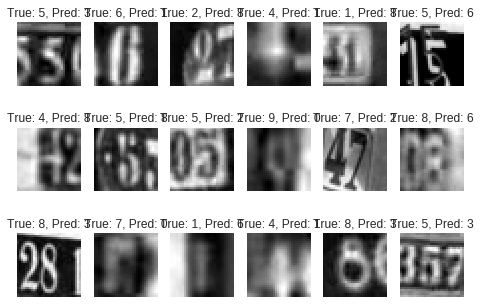

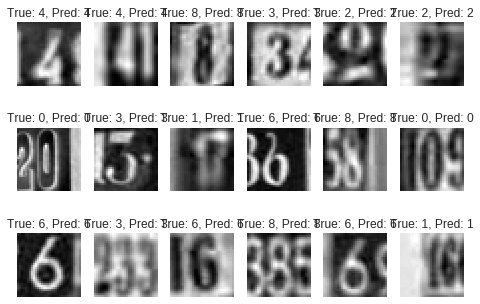

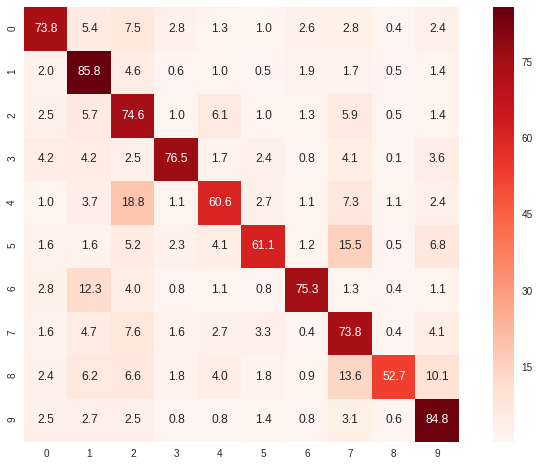

 total_cross_entropy [  0.        0.      101.36409 ...  99.74098   0.      561.82263]
 total_cross_entropy [0.0000000e+00 5.8690600e+00 3.8926147e+01 ... 0.0000000e+00 5.5825279e+01
 2.2661025e-03]
 total_cross_entropy [7.6762156e+00 1.7610756e+01 1.1920928e-07 ... 2.9351635e+01 1.7856865e+01
 1.3579945e+02]
 total_cross_entropy [ 0.       34.405064  0.       ...  0.       19.151184 39.4291  ]
 total_cross_entropy [ 10.749638  36.807247  68.69918  ...   0.         0.       172.59583 ]
 total_cross_entropy [ 51.301235     0.58349144 100.79519    ...  13.498681     9.584994
   0.        ]
 total_cross_entropy [ 1.4943465  0.4579249  0.        ...  0.        15.233269   5.144983 ]
 total_cross_entropy [ 0.       31.804987  0.       ...  0.       87.63368  62.136642]
 total_cross_entropy [ 0.         0.         1.4571409 ...  0.        42.471134  25.252583 ]
 total_cross_entropy [3.0071419e+01 1.0866987e-02 1.6526130e-01 ... 0.0000000e+00 4.1578266e+01
 1.4154756e+01]
 total_cross_entropy

 total_cross_entropy [34.10041  0.       0.      ...  0.       0.       0.     ]
 total_cross_entropy [2.5821358e+01 4.7683704e-07 0.0000000e+00 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
 total_cross_entropy [24.879107   0.         0.        ...  0.         0.         4.8391905]
 total_cross_entropy [1.1038289e+01 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00 1.6689287e-06
 0.0000000e+00]
 total_cross_entropy [2.5361696e+01 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00 0.0000000e+00
 2.3841855e-07]
 total_cross_entropy [5.0009239e+01 1.2623466e-04 0.0000000e+00 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
 total_cross_entropy [2.2588116e+01 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00 1.0013530e-05
 8.2407224e-01]
 test_accuracy 0.752901
[4 3 5 ... 3 1 2]


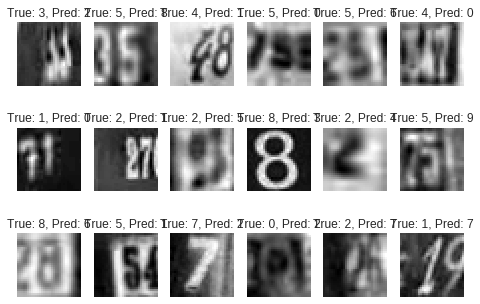

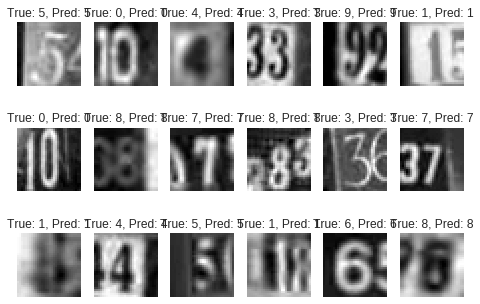

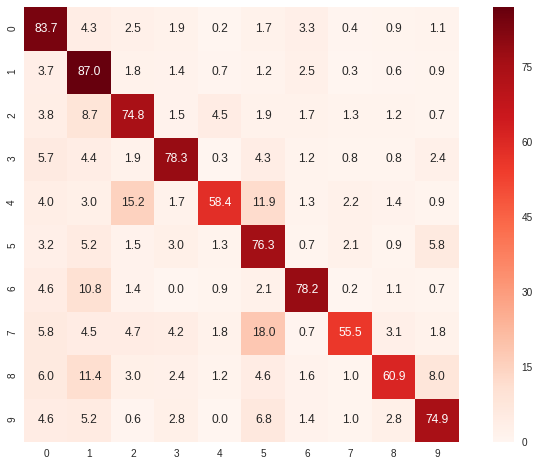

 total_cross_entropy [160.94495  215.90802   29.774887 ... 398.02332   54.028374 849.69    ]
 total_cross_entropy [41.702698 44.471035  0.       ...  0.       23.59181  49.12282 ]
 total_cross_entropy [6.2510658e+01 3.6135414e+01 2.5033919e-06 ... 0.0000000e+00 1.5870135e+02
 0.0000000e+00]
 total_cross_entropy [ 0.       61.499355  8.896172 ...  0.       73.53575  75.99531 ]
 total_cross_entropy [70.60254  70.37554   0.       ...  0.       33.969444 76.078804]
 total_cross_entropy [3.8883228e+01 4.1622192e+01 1.1920928e-07 ... 0.0000000e+00 5.2509426e+01
 2.2407364e+01]
 total_cross_entropy [ 8.2320595 36.322098   0.        ...  0.        19.914871   0.       ]
 total_cross_entropy [ 0.       17.968758  0.       ...  0.       21.942467 99.1051  ]
 total_cross_entropy [1.5515236e+01 5.5800774e+01 0.0000000e+00 ... 8.6916504e+00 7.4150116e+01
 1.4530557e-04]
 total_cross_entropy [3.0168354e+01 3.5856873e+01 0.0000000e+00 ... 0.0000000e+00 1.2182447e-04
 7.9376442e+01]
 total_cross_entro

 total_cross_entropy [ 0.      12.50972  0.      ...  0.       0.       0.     ]
 total_cross_entropy [0.0000000e+00 1.7903633e-04 0.0000000e+00 ... 0.0000000e+00 2.4191529e-01
 2.4366994e-01]
 total_cross_entropy [0. 0. 0. ... 0. 0. 0.]
 total_cross_entropy [2.4795225e-05 4.4749360e+00 1.4839233e+01 ... 0.0000000e+00 1.4424220e-05
 0.0000000e+00]
 total_cross_entropy [1.9921985 0.459952  0.        ... 0.        0.        0.       ]
 total_cross_entropy [0.04394315 0.         0.         ... 0.         3.3062184  7.106575  ]
 test_accuracy 0.75576794
[0 0 6 ... 7 4 9]


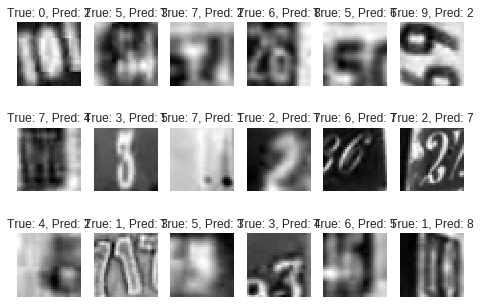

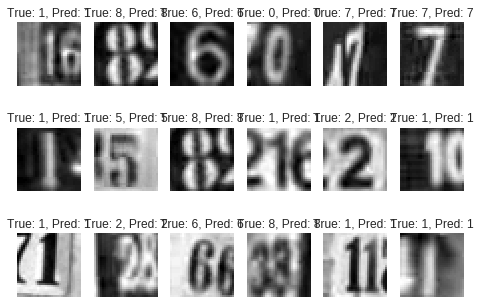

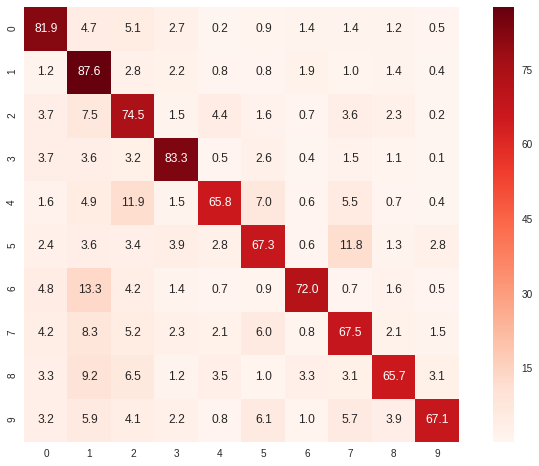

 total_cross_entropy [  2.2661946 139.81998   124.94512   ... 252.20612   463.30377
 898.2095   ]
 total_cross_entropy [69.03935  18.31893   0.       ... 33.081512 31.607986 56.62334 ]
 total_cross_entropy [ 21.901323  54.000484   0.       ...  11.162724 103.31499    0.      ]
 total_cross_entropy [20.584148   1.2514979  0.        ...  0.         3.7152336 31.679794 ]
 total_cross_entropy [3.6022134e-02 4.6171230e+01 1.6319593e+00 ... 0.0000000e+00 4.1698212e+01
 6.6078445e+01]
 total_cross_entropy [3.2555820e+01 1.4995404e-04 0.0000000e+00 ... 0.0000000e+00 6.0878768e+00
 1.8843393e+01]
 total_cross_entropy [7.7789562e-04 3.6365123e+00 2.5531097e+01 ... 0.0000000e+00 0.0000000e+00
 5.5828381e+01]
 total_cross_entropy [4.4107342e-06 4.1915054e+01 0.0000000e+00 ... 0.0000000e+00 0.0000000e+00
 5.1188515e+01]
 total_cross_entropy [2.4719597e+01 1.6028597e+00 2.7418098e-06 ... 0.0000000e+00 6.5080811e+01
 3.8129959e+01]
 total_cross_entropy [10.735264  16.650919  17.316284  ...  0.2711545

 total_cross_entropy [6.0275207e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00 0.0000000e+00
 2.7418098e-06]
 total_cross_entropy [3.5373985e+01 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00 1.4485405e+01
 1.4844838e-03]
 total_cross_entropy [4.7268648e-02 3.5762781e-07 0.0000000e+00 ... 0.0000000e+00 4.4178724e+00
 0.0000000e+00]
 total_cross_entropy [2.4158243e+01 1.1920922e-06 6.3363498e-04 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
 total_cross_entropy [8.7259024e-01 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00 0.0000000e+00
 1.1920928e-07]
 total_cross_entropy [8.7507982e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00 7.5538229e-04
 1.1920928e-07]
 test_accuracy 0.75139934
[5 1 0 ... 1 0 1]


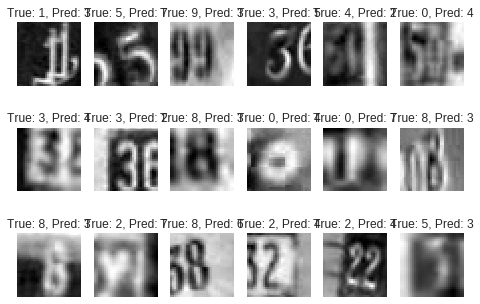

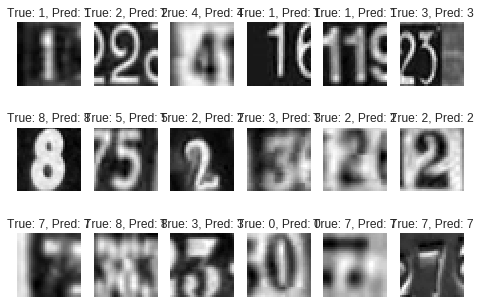

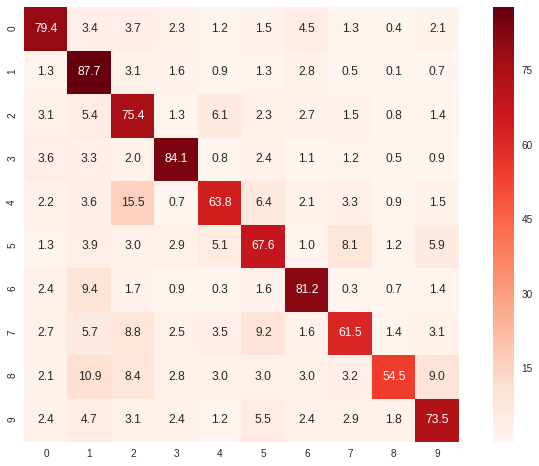

 total_cross_entropy [  0.        40.646057  17.567963 ... 266.6391   624.578    848.86395 ]
 total_cross_entropy [  9.554831  44.01921    2.540286 ...  38.67874   59.9411   109.24454 ]
 total_cross_entropy [16.069511  0.        0.       ... 58.873688 20.419407 75.32071 ]
 total_cross_entropy [1.2673083e+01 7.6293654e-06 2.1351532e+01 ... 0.0000000e+00 5.9958893e+01
 0.0000000e+00]
 total_cross_entropy [6.2039185e-01 3.3445103e+01 1.0220404e+01 ... 1.1920928e-07 5.6233551e+01
 3.7943909e+01]
 total_cross_entropy [1.3368128e+01 6.1145992e+00 0.0000000e+00 ... 0.0000000e+00 1.1811431e-03
 3.3773869e-01]
 total_cross_entropy [2.2895236e-01 5.0407967e+01 4.1405205e-02 ... 3.7094564e+00 1.5888698e-03
 6.1782637e+00]
 total_cross_entropy [ 0.       17.189165  0.       ... 38.606964  0.       26.4385  ]
 total_cross_entropy [ 0.         3.1104147  0.        ...  0.         0.        10.797719 ]
 total_cross_entropy [0.0000000e+00 3.4936043e+01 8.4960123e-04 ... 0.0000000e+00 2.7362786e-03
 5.

 total_cross_entropy [15.621057    0.02358781  0.         ...  0.          0.
  0.        ]
 total_cross_entropy [1.3529299e+01 0.0000000e+00 0.0000000e+00 ... 7.6293654e-06 0.0000000e+00
 0.0000000e+00]
 total_cross_entropy [8.9922702e-01 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00 2.8729763e+00
 4.7588945e-04]
 total_cross_entropy [8.836358   0.47672698 0.         ... 0.         0.         0.        ]
 total_cross_entropy [8.2753105 0.        0.        ... 0.        0.        0.       ]
 total_cross_entropy [0.25985807 0.         0.         ... 0.         0.         0.        ]
 test_accuracy 0.74648464
[6 3 5 ... 6 2 9]


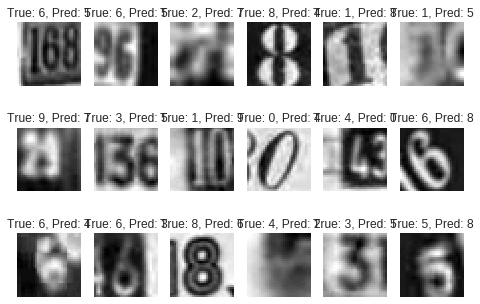

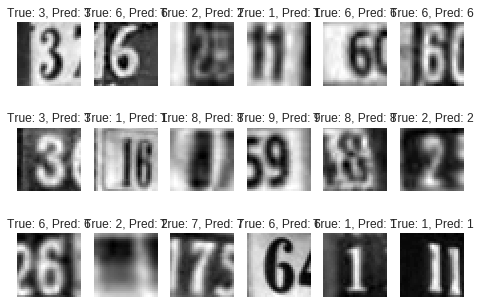

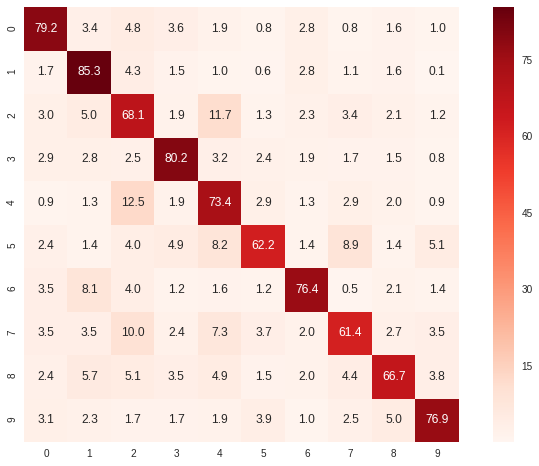

 total_cross_entropy [  0.        91.112144  55.784615 ... 329.7156   562.1796   518.90393 ]
 total_cross_entropy [  0.        81.27285    0.       ...  14.740326 136.08519    3.950451]
 total_cross_entropy [8.1914192e+01 6.6026009e+01 1.1920928e-07 ... 0.0000000e+00 3.0048576e+01
 0.0000000e+00]
 total_cross_entropy [10.780848 15.334095  0.       ... 63.924118 62.446472  0.      ]
 total_cross_entropy [ 0.       31.55198   0.       ...  0.       91.41303  14.738846]
 total_cross_entropy [8.88906128e-04 1.36532518e-03 0.00000000e+00 ... 0.00000000e+00
 1.19150305e+01 1.65202332e+01]
 total_cross_entropy [ 0.       20.649963  0.       ...  0.        0.       24.131456]
 total_cross_entropy [2.8476972e-02 4.6119461e+01 0.0000000e+00 ... 0.0000000e+00 2.8817009e+01
 4.9856140e+01]
 total_cross_entropy [1.7165990e-05 5.8374639e+00 0.0000000e+00 ... 0.0000000e+00 2.6797058e+01
 0.0000000e+00]
 total_cross_entropy [13.251509  30.54699    5.0226903 ...  0.        15.088502  48.540054 ]
 total

 total_cross_entropy [8.435855   0.50281197 0.         ... 0.         0.         0.        ]
 total_cross_entropy [ 1.1157047 22.328423   0.        ...  0.         0.         0.       ]
 total_cross_entropy [9.001535  0.        0.        ... 0.        2.8014944 0.       ]
 total_cross_entropy [4.4326506e+00 2.6190525e-03 0.0000000e+00 ... 0.0000000e+00 0.0000000e+00
 1.7844411e+00]
 total_cross_entropy [0.00857907 0.         0.         ... 0.         0.         0.00251466]
 total_cross_entropy [5.370610e-01 0.000000e+00 0.000000e+00 ... 0.000000e+00 0.000000e+00
 7.152555e-07]
 test_accuracy 0.74457335
[1 5 6 ... 3 6 2]


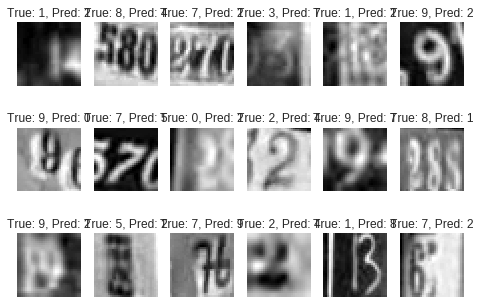

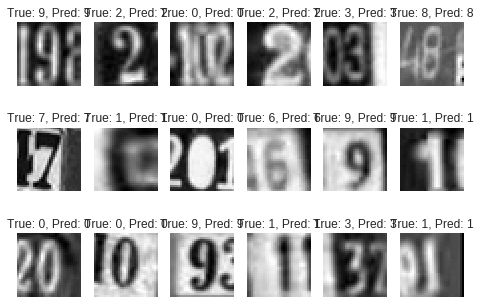

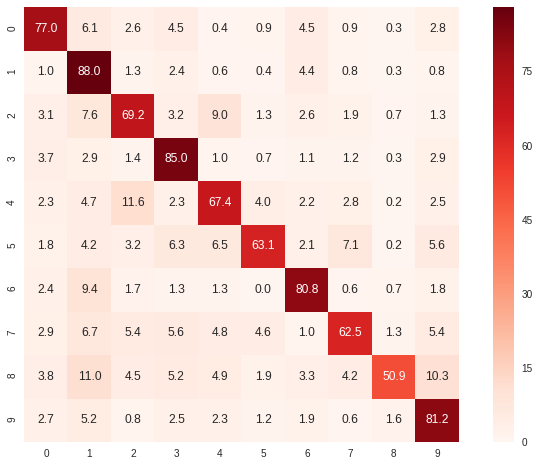

 total_cross_entropy [ 66.662735 212.70819  160.92667  ... 100.9191   528.55676  593.4403  ]
 total_cross_entropy [ 1.3685443 71.335014   0.        ...  9.380417  28.321291  52.7146   ]
 total_cross_entropy [2.1067810e+01 3.0652191e+01 0.0000000e+00 ... 4.1178329e-04 2.9090975e+01
 8.0422004e-04]
 total_cross_entropy [17.484129  0.        0.       ...  0.       30.86081   0.      ]
 total_cross_entropy [ 0.       43.960876  0.       ...  0.       38.4132   24.428198]
 total_cross_entropy [0.0000000e+00 4.0356122e-04 2.2532707e+01 ... 0.0000000e+00 2.6242882e+01
 4.2113976e+01]
 total_cross_entropy [76.67222   48.25676   48.800613  ...  0.         7.2807045 58.195    ]
 total_cross_entropy [1.4302266e+00 3.2669929e-04 3.0439019e-03 ... 0.0000000e+00 1.0728830e-06
 2.5233215e+01]
 total_cross_entropy [9.4395978e-03 2.9153339e+01 0.0000000e+00 ... 0.0000000e+00 1.3926328e+02
 2.6699316e-04]
 total_cross_entropy [2.9901718e+01 2.8653807e-04 5.4428069e-04 ... 0.0000000e+00 7.8594421e+01
 5.

 total_cross_entropy [1.1047517e+01 2.2194306e-04 0.0000000e+00 ... 0.0000000e+00 0.0000000e+00
 3.8820663e+01]
 total_cross_entropy [ 2.427978 19.559462  0.       ...  0.        0.        0.      ]
 total_cross_entropy [ 0.        0.        0.       ...  0.       18.551163 25.461695]
 total_cross_entropy [21.9692      0.          0.         ...  0.         19.89566
  0.78655314]
 total_cross_entropy [1.8714478e+01 5.9604628e-07 0.0000000e+00 ... 0.0000000e+00 9.2273295e-01
 0.0000000e+00]
 total_cross_entropy [13.499795  0.        0.       ...  0.        0.        0.      ]
 test_accuracy 0.7440273
[4 8 8 ... 8 1 3]


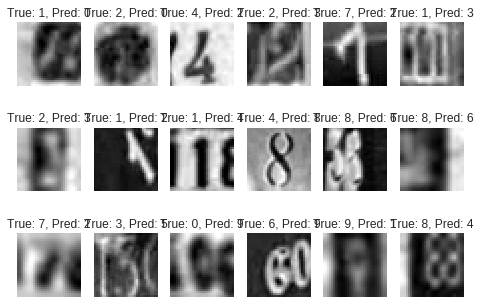

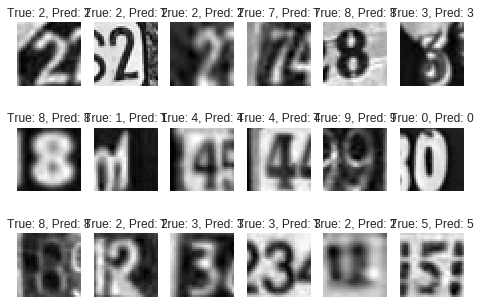

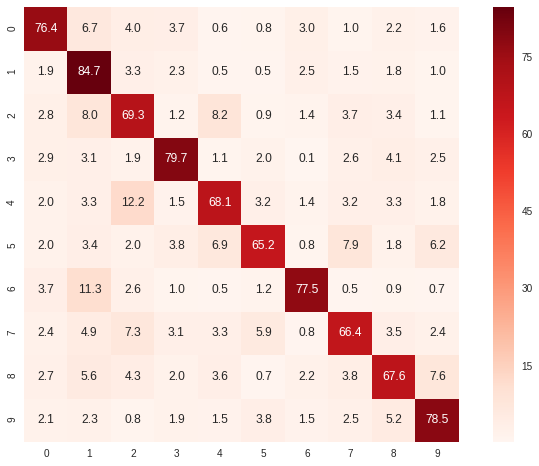

 total_cross_entropy [173.85971  138.5885    22.624084 ... 449.34027  769.40515  822.94855 ]
 total_cross_entropy [ 34.795578  49.418827  43.636887 ...   0.        71.787285 121.13903 ]
 total_cross_entropy [ 74.262535   8.211187  38.30659  ...   0.       103.08807   32.62194 ]
 total_cross_entropy [  4.2427416   0.         33.982452  ...   0.         28.768335
 129.39807  ]
 total_cross_entropy [0.0000000e+00 9.5367386e-07 7.2587234e+01 ... 2.6856830e-02 9.5652443e+01
 0.0000000e+00]
 total_cross_entropy [ 0.         0.        90.658295  ...  6.7579374  1.896906  37.974937 ]
 total_cross_entropy [3.1243980e+01 0.0000000e+00 3.4903076e+01 ... 0.0000000e+00 1.8487758e-03
 1.9102570e+01]
 total_cross_entropy [ 56.585     0.      139.2659  ...   0.      190.42915   0.     ]
 total_cross_entropy [ 0.        0.       63.318554 ...  0.       77.99228  52.171787]
 total_cross_entropy [ 0.08305186  0.         65.47842    ...  0.          0.
 25.645226  ]
 total_cross_entropy [0.0000000e+00 2.6

 total_cross_entropy [16.030132    0.93998086  0.         ...  0.          0.
 18.448446  ]
 total_cross_entropy [2.6049637e+01 2.3841855e-07 0.0000000e+00 ... 0.0000000e+00 0.0000000e+00
 2.1117377e+00]
 total_cross_entropy [0.0000000e+00 1.9073468e-06 0.0000000e+00 ... 0.0000000e+00 1.6822468e+01
 0.0000000e+00]
 total_cross_entropy [3.3764038e+01 4.3253205e-03 0.0000000e+00 ... 0.0000000e+00 1.8121989e-01
 1.1920928e-07]
 total_cross_entropy [3.8444576e+01 1.9635938e-03 0.0000000e+00 ... 0.0000000e+00 1.1920928e-07
 0.0000000e+00]
 total_cross_entropy [1.1594118e+01 8.3446469e-07 0.0000000e+00 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
 test_accuracy 0.75904435
[4 6 4 ... 0 0 0]


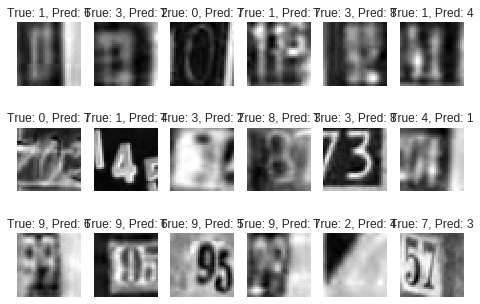

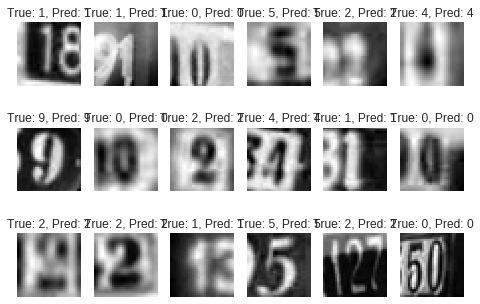

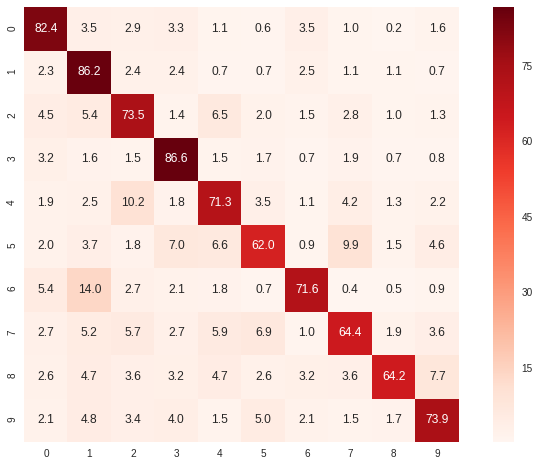

 total_cross_entropy [1.9497668e+02 1.1809911e+02 8.1061989e-06 ... 2.9406848e+02 5.9186218e+01
 3.7083710e+01]
 total_cross_entropy [4.2193206e-03 2.2031530e+01 5.5251269e+00 ... 0.0000000e+00 8.8336182e+01
 5.8363831e+01]
 total_cross_entropy [ 67.64453   56.079155   0.       ...   0.       102.679474   0.      ]
 total_cross_entropy [ 8.339956 57.346058  0.       ...  0.       28.134468  0.      ]
 total_cross_entropy [ 0.       82.88785   0.       ...  0.       47.653    39.287193]
 total_cross_entropy [ 0.       46.31485   0.       ...  0.       32.766212 84.929245]
 total_cross_entropy [1.0967195e-05 3.7638863e+01 8.8943787e+01 ... 0.0000000e+00 2.0265559e-06
 8.8183289e+01]
 total_cross_entropy [30.54955 35.03732  0.      ...  0.      35.80832 29.25837]
 total_cross_entropy [1.4288941e-03 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00 1.4942889e+02
 1.9140508e+02]
 total_cross_entropy [16.637833 26.499825  0.       ...  0.       47.361282 33.16773 ]
 total_cross_entropy [ 0.     

 total_cross_entropy [2.6244594e-02 1.1920928e-07 0.0000000e+00 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
 total_cross_entropy [1.43329477e+00 9.82712364e+00 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 1.12408045e-04]
 total_cross_entropy [0.        0.        0.        ... 0.        7.6076646 0.       ]
 total_cross_entropy [1.7191893e+01 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00 2.1855924e-02
 1.5497195e-06]
 total_cross_entropy [25.15469   0.        0.       ...  0.       17.324627  0.      ]
 total_cross_entropy [3.1623241e-01 4.7683704e-07 0.0000000e+00 ... 0.0000000e+00 1.9953644e-04
 0.0000000e+00]
 test_accuracy 0.745529
[0 0 7 ... 0 5 3]


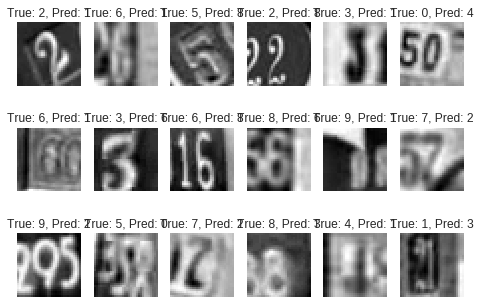

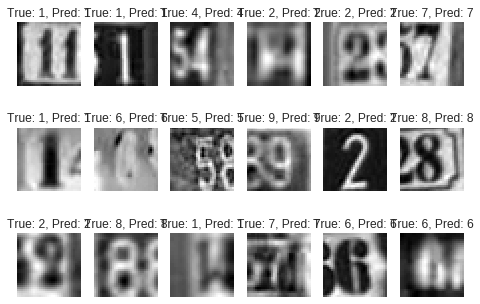

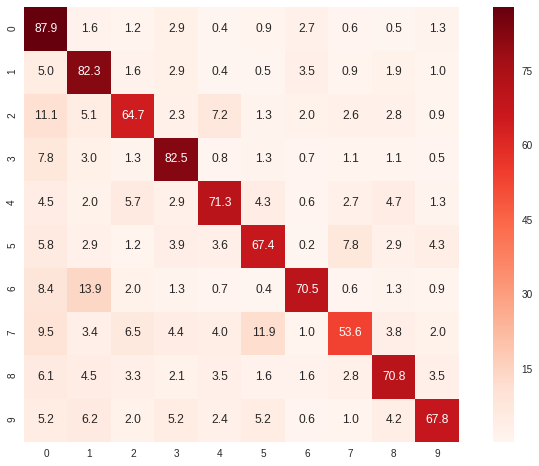

 total_cross_entropy [ 72.98839   0.      415.84436 ... 533.7134  255.51756 708.7235 ]
 total_cross_entropy [41.353554 44.475254  0.       ...  0.       97.16966  56.59754 ]
 total_cross_entropy [55.196175 77.645584 60.33873  ...  0.       98.51209  16.232327]
 total_cross_entropy [ 4.9582057 12.291638  22.892437  ...  0.        36.321526   0.       ]
 total_cross_entropy [0.0000000e+00 4.9578426e+01 5.8277695e+01 ... 0.0000000e+00 0.0000000e+00
 1.3174392e-02]
 total_cross_entropy [3.2186456e-06 4.7683704e-07 0.0000000e+00 ... 0.0000000e+00 4.5826530e+00
 0.0000000e+00]
 total_cross_entropy [ 0.74415046 29.897337    0.         ...  0.          0.
 19.849293  ]
 total_cross_entropy [ 65.772736    1.3282623  24.131416  ...   0.        140.4459
   0.       ]
 total_cross_entropy [  0.5975239   0.          0.        ...   0.         27.312841
 107.522995 ]
 total_cross_entropy [36.841957  19.620823   1.1027611 ...  0.        21.251022  50.38419  ]
 total_cross_entropy [0.0000000e+00 0.000

In [0]:
for i in range(10):
    X_train,  y_train,X_test, y_test=train_test_split_10(train_X, train_y, i)
    test_pred=train(X_train,y_train,X_test,y_test)
    train_data_img,_,test_data_img,_=train_test_split_10(data["X"].transpose((3, 0, 1, 2)), data["y"],i)
    analysis(test_pred,y_test,test_data_img)

###Method5---CNN

####preprocessing

In [0]:
from __future__ import print_function
from scipy.io import loadmat as load
from sklearn.preprocessing import OneHotEncoder
import os
import time
import numpy as np
from datetime import timedelta

load data

In [0]:
train= load("train_32x32.mat") # data is train['X'], label is train['y']
validation= load('test_32x32.mat')

seperate data and label

In [0]:
def seprate_data(data, type='data'):
    if type == 'data':
        number_of_training_data = data.shape[3]
        data = data.transpose((3, 0, 1, 2))

    else:
        number_of_training_data = data.shape[0]
        data = data.flatten()
        data[data == 10] = 0

    return data


train_data_t = seprate_data(train['X'],  type='data')
print('train_data_t_shape', train_data_t.shape)
train_labels_t = seprate_data(train['y'],  type='label')
# train_labels_t=np.array(train_labels_t)
print('train_labels_t_shape', np.shape(train_labels_t))

validation_data_t = seprate_data(validation['X'],  type='data')
print('train_data_t_shape', validation_data_t.shape)
validation_labels_t = seprate_data(validation['y'],  type='label')
# train_labels_t=np.array(train_labels_t)
print('train_labels_t_shape', np.shape(validation_labels_t))


train_data_t_shape (73257, 32, 32, 3)
train_labels_t_shape (73257,)
train_data_t_shape (26032, 32, 32, 3)
train_labels_t_shape (26032,)


Fit the OneHotEncoder

In [0]:
enc = OneHotEncoder().fit(train_labels_t.reshape(-1, 1))
validation_enc = OneHotEncoder().fit(validation_labels_t.reshape(-1, 1))

# Transform the label values to a one-hot-encoding scheme
train_labels_t = enc.transform(train_labels_t.reshape(-1, 1)).toarray()

validation_labels_t = validation_enc.transform(validation_labels_t.reshape(-1, 1)).toarray()

greyscale

In [0]:
image_size = 32
pixel_depth = 255.0

def im2gray(image):
    '''Normalize images'''
    image = image.astype(float)

    image_gray = np.dot(image, [[0.2989],[0.5870],[0.1140]])
    return image_gray

train_data_c = im2gray(np.array(train_data_t))[:,:,:,0]

validation_data_c = im2gray(np.array(validation_data_t))[:,:,:,0]

print('train_data_c _shape:',train_data_c.shape)

train_data_c _shape: (73257, 32, 32)


Regularization

In [0]:
def GCN(image, min_divisor=1e-4):
    """Global Contrast Normalization"""

    imsize = image.shape[0]
    mean = np.mean(image, axis=(1, 2), dtype=float)
    std = np.std(image, axis=(1, 2), dtype=float, ddof=1)
    std[std < min_divisor] = 1.
    image_GCN = np.zeros(image.shape, dtype=float)

    for i in np.arange(imsize):
        image_GCN[i, :, :] = (image[i, :, :] - mean[i]) / std[i]

    return image_GCN


train_data_GCN = GCN(train_data_c)

validation_data_GCN = GCN(validation_data_c)

print(train_data_GCN.shape, np.shape(train_labels_t))

(73257, 32, 32) (73257, 10)


####machine learning technique

In [0]:
import tensorflow as tf

Attach a lot of summaries to a Tensor

In [0]:
def variable_summaries(var):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

input data size

In [0]:
img_size = train_data_GCN.shape[1]

num_channels = 1

num_classes = train_labels_t.shape[1]

helper function

In [0]:
def conv_weight_variable(layer_name, shape):
    return tf.get_variable(layer_name, shape=shape, initializer=tf.contrib.layers.xavier_initializer_conv2d())

def fc_weight_variable(layer_name, shape):
    return tf.get_variable(layer_name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(shape):
    return tf.Variable(tf.constant(0.0, shape=shape))

def conv_layer(input,
               layer_name,
               num_input_channels,
               filter_size,
               num_filters,
               pooling=True):

    shape = [filter_size, filter_size, num_input_channels, num_filters]
    with tf.name_scope(layer_name):
        with tf.name_scope('cnn_weights'):
            weights = conv_weight_variable(layer_name, shape=shape)
            variable_summaries(weights)
        with tf.name_scope('cnn_biases'):
            biases = bias_variable(shape=[num_filters])
            variable_summaries(biases)
        with tf.name_scope('cnn_layer'):
            layer = tf.nn.conv2d(input=input,
                                 filter=weights,
                                 strides=[1, 1, 1, 1],
                                 padding='SAME')
            layer += biases
            tf.summary.histogram('cnn_pre_layer', layer)
        layer = tf.nn.relu(layer)
        tf.summary.histogram('cnn_layer', layer)

        if pooling:
            with tf.name_scope('pool_layer'):
                layer = tf.nn.max_pool(value=layer,
                                       ksize=[1, 2, 2, 1],
                                       strides=[1, 2, 2, 1],
                                       padding='SAME')
                tf.summary.histogram('pool_layer', layer)
    return layer, weights

def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

def fc_layer(input,
             layer_name,
             num_inputs,
             num_outputs,
             relu=True):
    with tf.name_scope(layer_name):
        with tf.name_scope('fc_weights'):
            weights = fc_weight_variable(layer_name, shape=[num_inputs, num_outputs])
            variable_summaries(weights)
        with tf.name_scope('fc_biases'):
            biases = bias_variable(shape=[num_outputs])
            variable_summaries(biases)
        with tf.name_scope('fc_layer'):
            layer = tf.matmul(input, weights) + biases
            tf.summary.histogram('pre_activations', layer)
        if relu:
            layer = tf.nn.relu(layer)
            tf.summary.histogram('activations', layer)
    return layer

cnn parameters

In [0]:
# Convolutional Layer 1.
filter_size1 = 5
num_filters1 = 32
# Convolutional Layer 2.
filter_size2 = 5
num_filters2 = 64
# Fully-connected layer.
fc_size = 256
# Number of training samples in each iteration
batch_size = 64
dropout = 0.5
total_iterations = 0

training function

In [0]:
def train(train_data_GCN, train_labels, test_data_GCN, test_labels, validation_data_GCN, validation_labels_t, K):
    tf.reset_default_graph()

    with tf.name_scope('input'):
        x = tf.placeholder(tf.float32, shape=(None, img_size, img_size, num_channels), name='x')
        y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')
        keep_prob = tf.placeholder(tf.float32)

    train_data_GCN = train_data_GCN.reshape(train_data_GCN.shape[0], train_data_GCN.shape[1], train_data_GCN.shape[2],
                                            1)
    test_data_GCN = test_data_GCN.reshape(test_data_GCN.shape[0], test_data_GCN.shape[1], test_data_GCN.shape[2], 1)
    validation_data_GCN = validation_data_GCN.reshape(validation_data_GCN.shape[0], validation_data_GCN.shape[1],
                                                      validation_data_GCN.shape[2], 1)
    print(np.shape(train_data_GCN))



    y_true_cls = tf.argmax(y_true, dimension=1)



    #
    conv_1, w_c1 = conv_layer(input=x,
                              layer_name="conv_1",
                              num_input_channels=num_channels,
                              filter_size=filter_size1,
                              num_filters=num_filters1, pooling=True)

    conv_1
    #
    conv_2, w_c2 = conv_layer(input=conv_1,
                              layer_name="conv_2",
                              num_input_channels=num_filters1,
                              filter_size=filter_size2,
                              num_filters=num_filters2,
                              pooling=True)

    dropout = tf.nn.dropout(conv_2, keep_prob)

    dropout
    #
    layer_flat, num_features = flatten_layer(dropout)

    layer_flat
    #

    fc_1 = fc_layer(input=layer_flat,
                    layer_name="fc_1",
                    num_inputs=num_features,
                    num_outputs=fc_size,
                    relu=True)

    fc_1
    #
    fc_2 = fc_layer(input=fc_1,
                    layer_name="fc_2",
                    num_inputs=fc_size,
                    num_outputs=num_classes,
                    relu=False)

    fc_2
    #

    y_pred = tf.nn.softmax(fc_2)
    y_pred_cls = tf.argmax(y_pred, dimension=1)

    with tf.name_scope('cross_entropy'):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=fc_2, labels=y_true)
        cost = tf.reduce_mean(cross_entropy)
    tf.summary.scalar('cross_entropy', cost)

    global_step = tf.Variable(0)

    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.96, staircase=True)

    with tf.name_scope('optimizer'):
        optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(cost, global_step=global_step)

    with tf.name_scope('accuracy'):
        with tf.name_scope('correct_prediction'):
            correct_prediction = tf.equal(y_pred_cls, y_true_cls)
        with tf.name_scope('accuracy'):
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy)


    saver = tf.train.Saver()
    save_dir = "./modelfor_" + str(K) + "/"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    save_path = save_dir

    with tf.Session() as sess:

        merged = tf.summary.merge_all()
        train_writer = tf.summary.FileWriter('./log_cnn' + str(K)+ '/train',
                                             sess.graph)
        test_writer = tf.summary.FileWriter('./log_cnn' + str(K)+ '/test')

        sess.run(tf.initialize_all_variables())

        num_iterations = 50000
        display_step = 5000
        X_train = train_data_GCN
        y_train = train_labels
        X_test = test_data_GCN
        y_test = test_labels
        X_val = validation_data_GCN
        y_val = validation_labels_t

        global total_iterations

        start_time = time.time()
        for step in range(num_iterations):

            offset = (step * batch_size) % (y_train.shape[0] - batch_size)
            batch_data = X_train[offset:(offset + batch_size), :, :, :]
            batch_labels = y_train[offset:(offset + batch_size), :]

            dropout = 0.5
            feed_dict_train = {x: batch_data, y_true: batch_labels, keep_prob: dropout}
            summary, _ =sess.run([merged,optimizer], feed_dict=feed_dict_train)
            train_writer.add_summary(summary, i)
            if step % display_step == 0:
                batch_acc = sess.run(accuracy, feed_dict=feed_dict_train)
                print("Minibatch accuracy at step %d: %.4f" % (step, batch_acc))
                validation_acc = sess.run(accuracy, {x: X_test, y_true: y_test, keep_prob: 1.0})
                # test_writer.add_summary(summary, i)
                print("Validation accuracy: %.4f" % validation_acc)


        total_iterations += num_iterations
        time_diff = time.time() - start_time
        summary,test_accuracy = sess.run([merged,accuracy], {x: X_val, y_true: y_val, keep_prob: 1.0})
        test_writer.add_summary(summary, i)
        print("Test accuracy: %.4f" % test_accuracy)
        print("Time usage: " + str(timedelta(seconds=int(round(time_diff)))))
        saver.save(sess=sess, save_path=save_path)

        test_pred = sess.run(y_pred_cls, {x: validation_data_GCN, y_true: validation_labels_t, keep_prob: 1.0})

    return test_pred

10-flod cross validation

In [0]:
def train_test_split_10(train_X, train_y, k):
    num_of_examples = len(train_X)
    start_jump = (num_of_examples // 10) * k
    end_jump = (num_of_examples // 10) * (k + 1)
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    for i in range(len(train_X)):
        if i <= start_jump:
            X_train.append(train_X[i])
            y_train.append(train_y[i])
        elif i > end_jump:
            X_train.append(train_X[i])
            y_train.append(train_y[i])
        else:
            X_test.append(train_X[i])
            y_test.append(train_y[i])

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    return X_train,  y_train,X_test, y_test

print function

In [0]:
import matplotlib.pyplot as plt
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    fig, axes = plt.subplots(nrows, ncols)
    rs = np.random.choice(images.shape[0], nrows * ncols)
    for i, ax in zip(rs, axes.flat):
        if cls_pred is None:
            title = "True: {0}".format(np.argmax(cls_true[i]))
        else:
            title = "True: {0}, Pred: {1}".format(np.argmax(cls_true[i]), cls_pred[i])

        ax.imshow(images[i, :, :, 0], cmap='binary')
        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])
        # ax.tight_layout()

analysis function

In [0]:
import seaborn as sns
from sklearn.metrics import  confusion_matrix
def analysis(test_pred, validation_data_GCN):
    incorrect = test_pred != np.argmax(validation_labels_t, axis=1)
    print(test_pred)
    temp = validation_data_GCN.reshape(validation_data_GCN.shape[0], validation_data_GCN.shape[1],
                                       validation_data_GCN.shape[2], 1)

    # Select the incorrectly classified examples
    images = temp[incorrect]
    cls_true = validation_labels_t[incorrect]
    cls_pred = test_pred[incorrect]

    # Plot the mis-classified examples
    plot_images(images, 3, 6, cls_true, cls_pred)

    correct = np.invert(incorrect)

    # Select the correctly classified examples
    images = temp[correct]
    cls_true = validation_labels_t[correct]
    cls_pred = test_pred[correct]

    # Plot the mis-classified examples
    plot_images(images, 3, 6, cls_true, cls_pred)

    plt.figure(figsize=(12, 8))

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true=np.argmax(validation_labels_t, axis=1), y_pred=test_pred)

    # Normalize the confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0

    # Visualize the confusion matrix
    sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True);
    plt.show()

(65932, 32, 32, 1)
Minibatch accuracy at step 0: 0.1562
Validation accuracy: 0.1907
Minibatch accuracy at step 5000: 0.9531
Validation accuracy: 0.9192
Minibatch accuracy at step 10000: 0.9688
Validation accuracy: 0.9263
Minibatch accuracy at step 15000: 1.0000
Validation accuracy: 0.9294
Minibatch accuracy at step 20000: 0.9844
Validation accuracy: 0.9283
Minibatch accuracy at step 25000: 0.9844
Validation accuracy: 0.9287
Minibatch accuracy at step 30000: 0.9844
Validation accuracy: 0.9323
Minibatch accuracy at step 35000: 0.9844
Validation accuracy: 0.9323
Minibatch accuracy at step 40000: 0.9844
Validation accuracy: 0.9306
Minibatch accuracy at step 45000: 1.0000
Validation accuracy: 0.9331
Test accuracy: 0.9283
Time usage: 0:07:01
[5 2 1 ... 7 6 7]


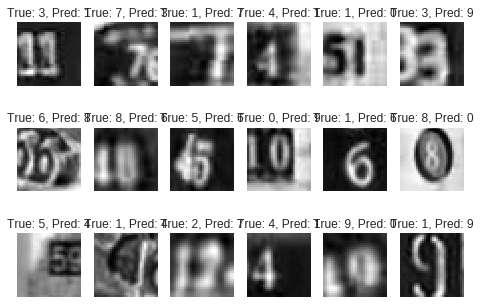

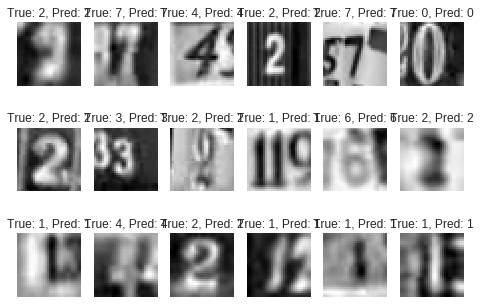

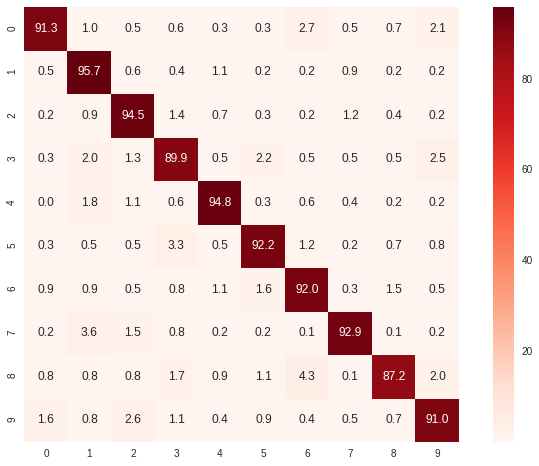

(65932, 32, 32, 1)
Minibatch accuracy at step 0: 0.2500
Validation accuracy: 0.1459
Minibatch accuracy at step 5000: 0.9844
Validation accuracy: 0.9223
Minibatch accuracy at step 10000: 0.9688
Validation accuracy: 0.9276
Minibatch accuracy at step 15000: 1.0000
Validation accuracy: 0.9287
Minibatch accuracy at step 20000: 1.0000
Validation accuracy: 0.9282
Minibatch accuracy at step 25000: 1.0000
Validation accuracy: 0.9328
Minibatch accuracy at step 30000: 1.0000
Validation accuracy: 0.9324
Minibatch accuracy at step 35000: 1.0000
Validation accuracy: 0.9317
Minibatch accuracy at step 40000: 1.0000
Validation accuracy: 0.9300
Minibatch accuracy at step 45000: 1.0000
Validation accuracy: 0.9316
Test accuracy: 0.9286
Time usage: 0:07:00
[5 2 1 ... 7 6 7]


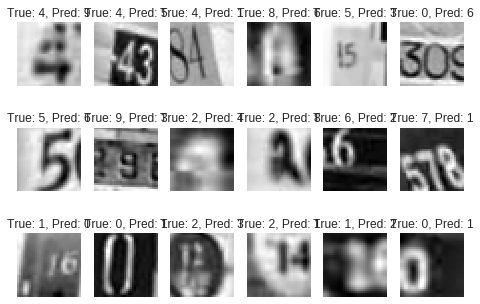

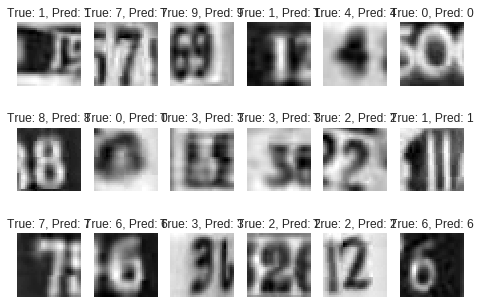

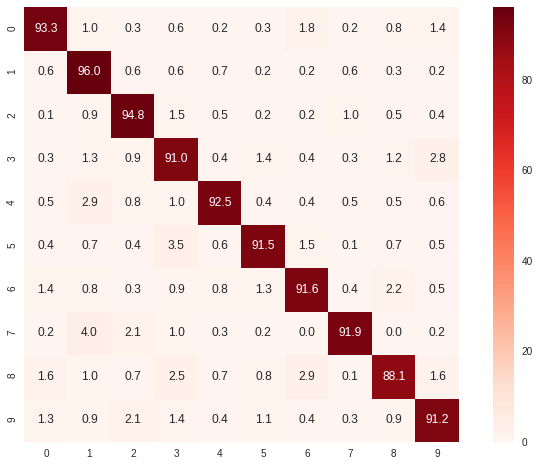

(65932, 32, 32, 1)
Minibatch accuracy at step 0: 0.1875
Validation accuracy: 0.1641
Minibatch accuracy at step 5000: 0.9219
Validation accuracy: 0.9136
Minibatch accuracy at step 10000: 0.9844
Validation accuracy: 0.9230
Minibatch accuracy at step 15000: 1.0000
Validation accuracy: 0.9245
Minibatch accuracy at step 20000: 0.9844
Validation accuracy: 0.9261
Minibatch accuracy at step 25000: 1.0000
Validation accuracy: 0.9249
Minibatch accuracy at step 30000: 0.9844
Validation accuracy: 0.9249
Minibatch accuracy at step 35000: 0.9844
Validation accuracy: 0.9279
Minibatch accuracy at step 40000: 1.0000
Validation accuracy: 0.9259
Minibatch accuracy at step 45000: 1.0000
Validation accuracy: 0.9264
Test accuracy: 0.9251
Time usage: 0:06:59
[5 2 1 ... 7 6 7]


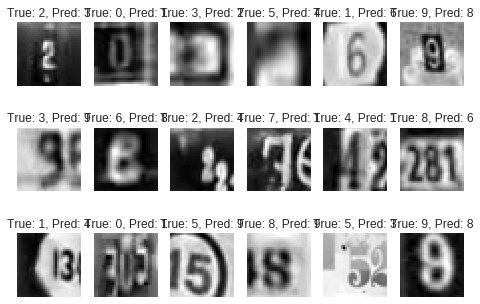

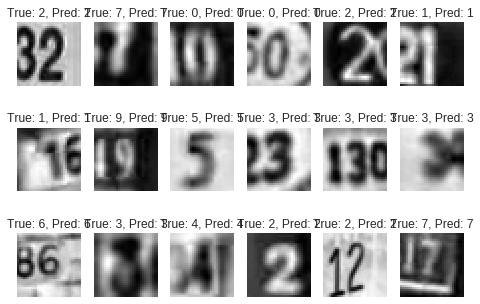

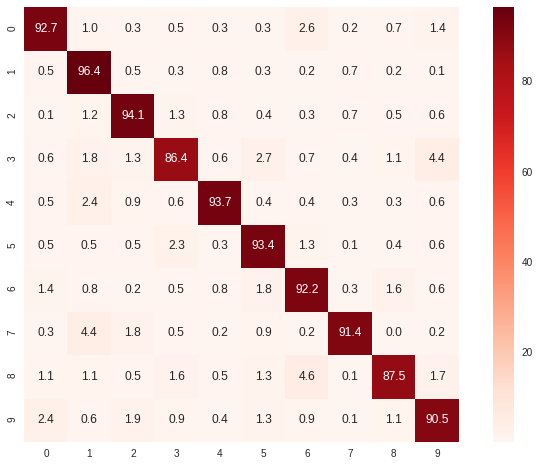

(65932, 32, 32, 1)
Minibatch accuracy at step 0: 0.2500
Validation accuracy: 0.1438
Minibatch accuracy at step 5000: 0.9062
Validation accuracy: 0.9214
Minibatch accuracy at step 10000: 0.9375
Validation accuracy: 0.9266
Minibatch accuracy at step 15000: 0.9844
Validation accuracy: 0.9274
Minibatch accuracy at step 20000: 0.9844
Validation accuracy: 0.9282
Minibatch accuracy at step 25000: 1.0000
Validation accuracy: 0.9281
Minibatch accuracy at step 30000: 1.0000
Validation accuracy: 0.9312
Minibatch accuracy at step 35000: 0.9688
Validation accuracy: 0.9308
Minibatch accuracy at step 40000: 1.0000
Validation accuracy: 0.9312
Minibatch accuracy at step 45000: 0.9844
Validation accuracy: 0.9317
Test accuracy: 0.9285
Time usage: 0:06:58
[5 2 1 ... 7 6 7]


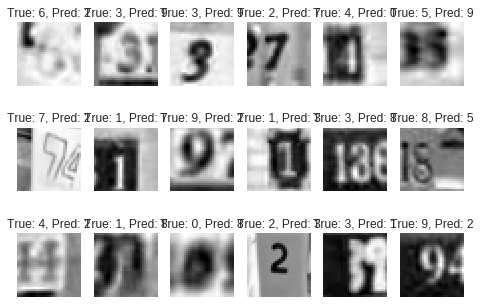

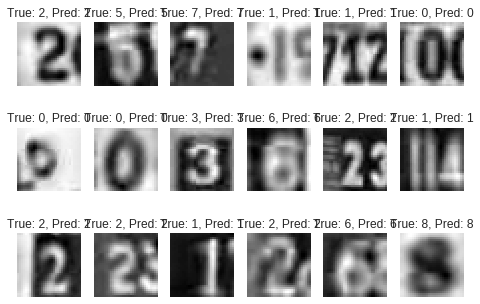

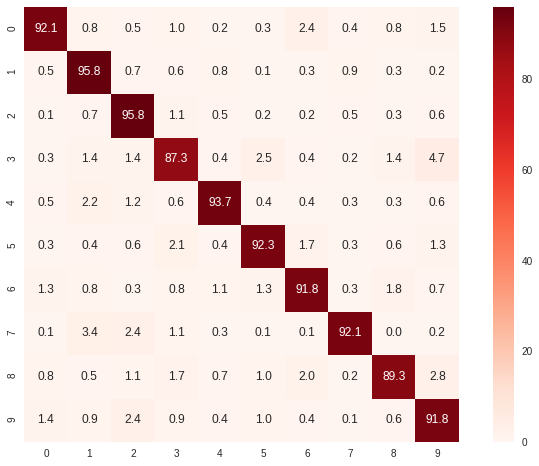

(65932, 32, 32, 1)
Minibatch accuracy at step 0: 0.2344
Validation accuracy: 0.1461
Minibatch accuracy at step 5000: 0.9688
Validation accuracy: 0.9203
Minibatch accuracy at step 10000: 0.9531
Validation accuracy: 0.9261
Minibatch accuracy at step 15000: 1.0000
Validation accuracy: 0.9242
Minibatch accuracy at step 20000: 0.9688
Validation accuracy: 0.9261
Minibatch accuracy at step 25000: 0.9531
Validation accuracy: 0.9260
Minibatch accuracy at step 30000: 1.0000
Validation accuracy: 0.9286
Minibatch accuracy at step 35000: 0.9844
Validation accuracy: 0.9317
Minibatch accuracy at step 40000: 0.9844
Validation accuracy: 0.9308
Minibatch accuracy at step 45000: 1.0000
Validation accuracy: 0.9301
Test accuracy: 0.9290
Time usage: 0:07:02
[5 2 1 ... 7 6 7]


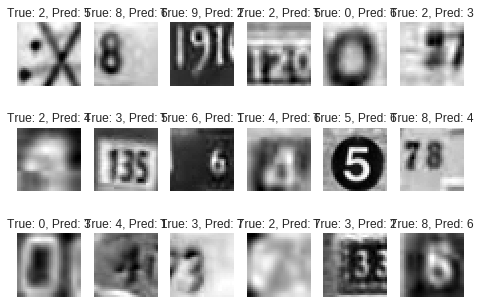

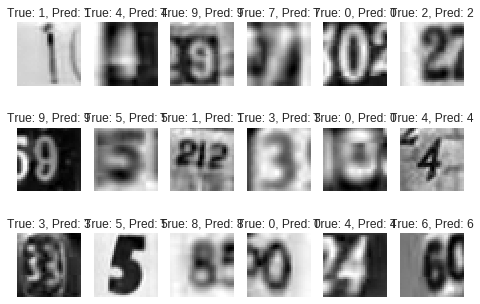

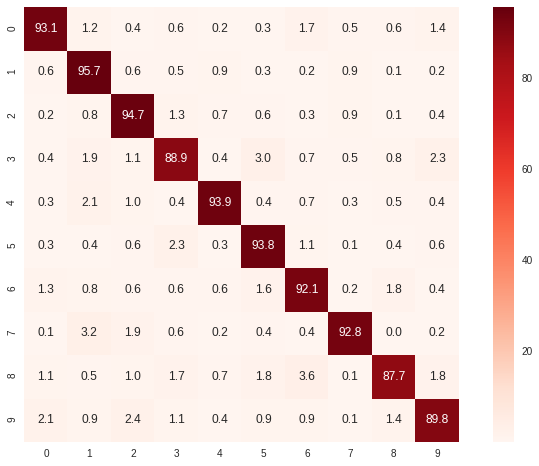

(65932, 32, 32, 1)
Minibatch accuracy at step 0: 0.2344
Validation accuracy: 0.1481
Minibatch accuracy at step 5000: 0.9375
Validation accuracy: 0.9268
Minibatch accuracy at step 10000: 0.9844
Validation accuracy: 0.9320
Minibatch accuracy at step 15000: 1.0000
Validation accuracy: 0.9341
Minibatch accuracy at step 20000: 1.0000
Validation accuracy: 0.9328
Minibatch accuracy at step 25000: 0.9844
Validation accuracy: 0.9347
Minibatch accuracy at step 30000: 1.0000
Validation accuracy: 0.9368
Minibatch accuracy at step 35000: 0.9688
Validation accuracy: 0.9377
Minibatch accuracy at step 40000: 1.0000
Validation accuracy: 0.9357
Minibatch accuracy at step 45000: 1.0000
Validation accuracy: 0.9391
Test accuracy: 0.9301
Time usage: 0:07:01
[5 2 1 ... 7 6 7]


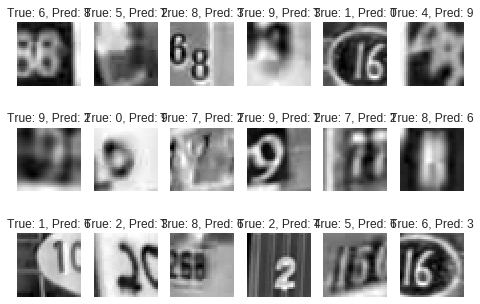

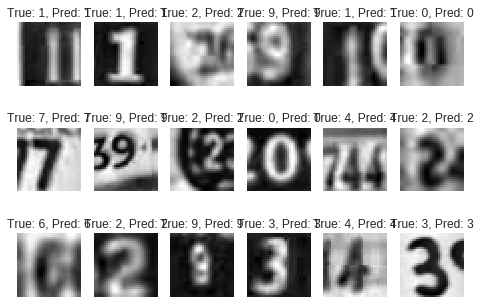

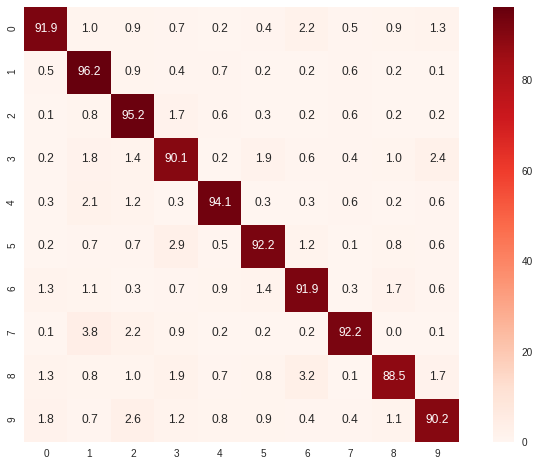

(65932, 32, 32, 1)
Minibatch accuracy at step 0: 0.2344
Validation accuracy: 0.1433
Minibatch accuracy at step 5000: 0.9531
Validation accuracy: 0.9218
Minibatch accuracy at step 10000: 0.9844
Validation accuracy: 0.9252
Minibatch accuracy at step 15000: 1.0000
Validation accuracy: 0.9268
Minibatch accuracy at step 20000: 1.0000
Validation accuracy: 0.9272
Minibatch accuracy at step 25000: 0.9844
Validation accuracy: 0.9308
Minibatch accuracy at step 30000: 0.9844
Validation accuracy: 0.9296
Minibatch accuracy at step 35000: 1.0000
Validation accuracy: 0.9275
Minibatch accuracy at step 40000: 1.0000
Validation accuracy: 0.9335
Minibatch accuracy at step 45000: 0.9844
Validation accuracy: 0.9342
Test accuracy: 0.9291
Time usage: 0:07:01
[5 2 1 ... 7 6 7]


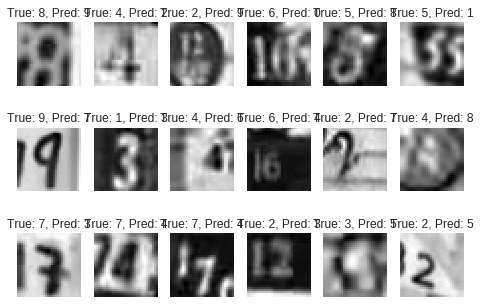

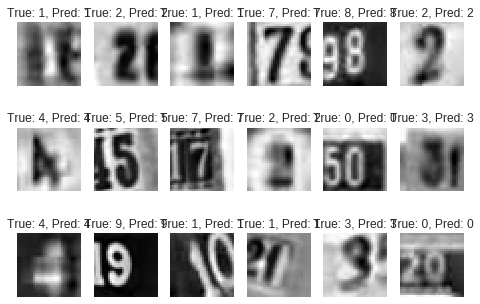

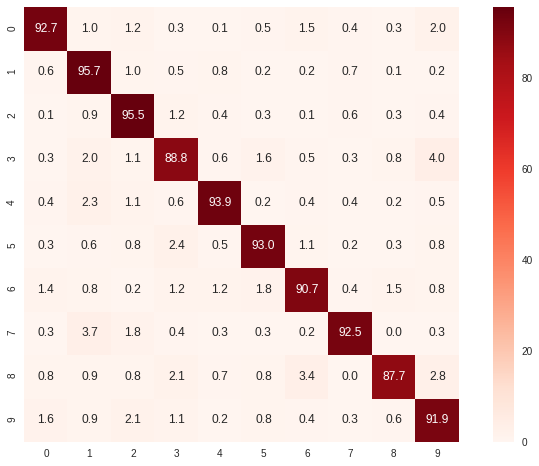

(65932, 32, 32, 1)
Minibatch accuracy at step 0: 0.2344
Validation accuracy: 0.1425
Minibatch accuracy at step 5000: 0.9375
Validation accuracy: 0.9192
Minibatch accuracy at step 10000: 0.9688
Validation accuracy: 0.9259
Minibatch accuracy at step 15000: 0.9844
Validation accuracy: 0.9227
Minibatch accuracy at step 20000: 1.0000
Validation accuracy: 0.9233
Minibatch accuracy at step 25000: 0.9688
Validation accuracy: 0.9285
Minibatch accuracy at step 30000: 0.9688
Validation accuracy: 0.9270
Minibatch accuracy at step 35000: 0.9844
Validation accuracy: 0.9312
Minibatch accuracy at step 40000: 0.9844
Validation accuracy: 0.9300
Minibatch accuracy at step 45000: 1.0000
Validation accuracy: 0.9320
Test accuracy: 0.9271
Time usage: 0:07:01
[5 2 1 ... 7 6 7]


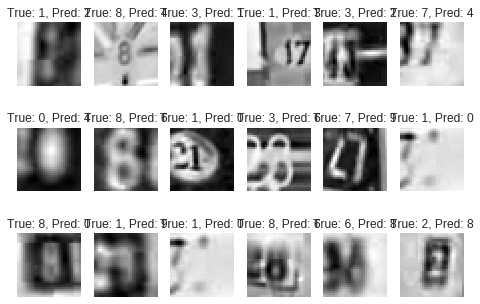

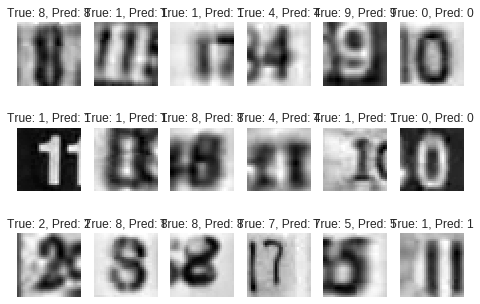

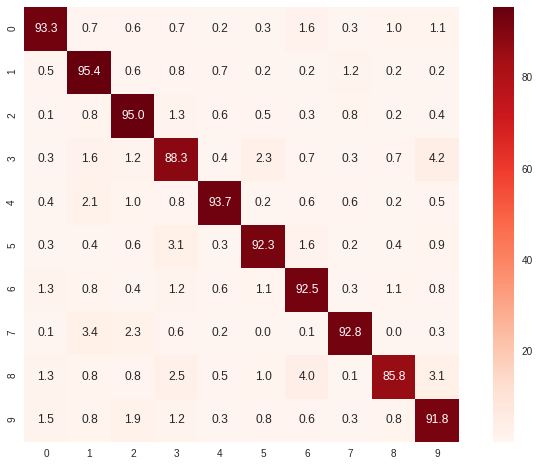

(65932, 32, 32, 1)
Minibatch accuracy at step 0: 0.2344
Validation accuracy: 0.1481
Minibatch accuracy at step 5000: 0.9844
Validation accuracy: 0.9237
Minibatch accuracy at step 10000: 1.0000
Validation accuracy: 0.9272
Minibatch accuracy at step 15000: 0.9688
Validation accuracy: 0.9287
Minibatch accuracy at step 20000: 1.0000
Validation accuracy: 0.9251
Minibatch accuracy at step 25000: 1.0000
Validation accuracy: 0.9323
Minibatch accuracy at step 30000: 1.0000
Validation accuracy: 0.9282
Minibatch accuracy at step 35000: 0.9844
Validation accuracy: 0.9301
Minibatch accuracy at step 40000: 1.0000
Validation accuracy: 0.9311
Minibatch accuracy at step 45000: 1.0000
Validation accuracy: 0.9342
Test accuracy: 0.9282
Time usage: 0:07:05
[5 2 1 ... 7 6 7]


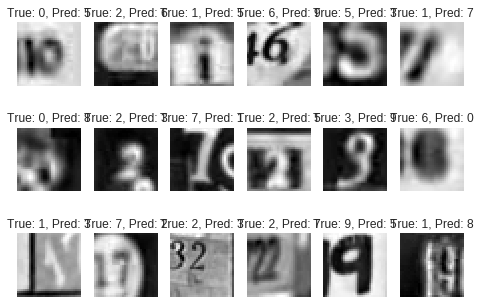

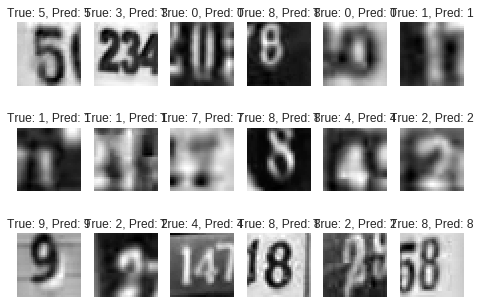

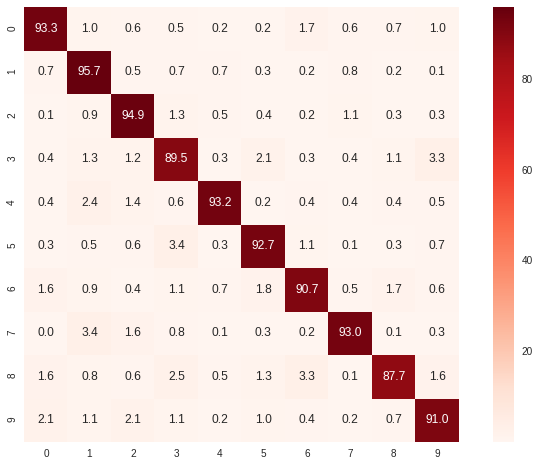

(65932, 32, 32, 1)
Minibatch accuracy at step 0: 0.2500
Validation accuracy: 0.1409
Minibatch accuracy at step 5000: 0.9688
Validation accuracy: 0.9240
Minibatch accuracy at step 10000: 1.0000
Validation accuracy: 0.9300
Minibatch accuracy at step 15000: 1.0000
Validation accuracy: 0.9293
Minibatch accuracy at step 20000: 0.9688
Validation accuracy: 0.9320
Minibatch accuracy at step 25000: 0.9844
Validation accuracy: 0.9324
Minibatch accuracy at step 30000: 0.9844
Validation accuracy: 0.9324
Minibatch accuracy at step 35000: 1.0000
Validation accuracy: 0.9316
Minibatch accuracy at step 40000: 0.9688
Validation accuracy: 0.9337
Minibatch accuracy at step 45000: 1.0000
Validation accuracy: 0.9343
Test accuracy: 0.9280
Time usage: 0:07:03
[5 2 1 ... 7 6 7]


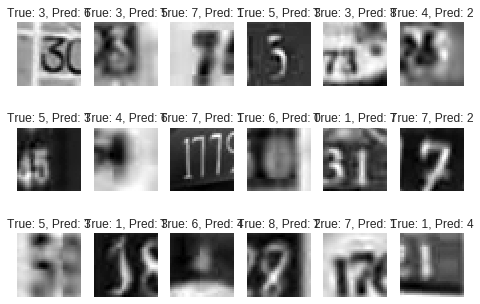

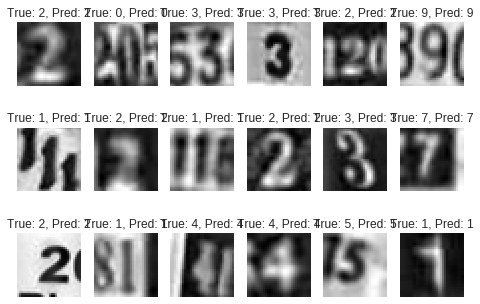

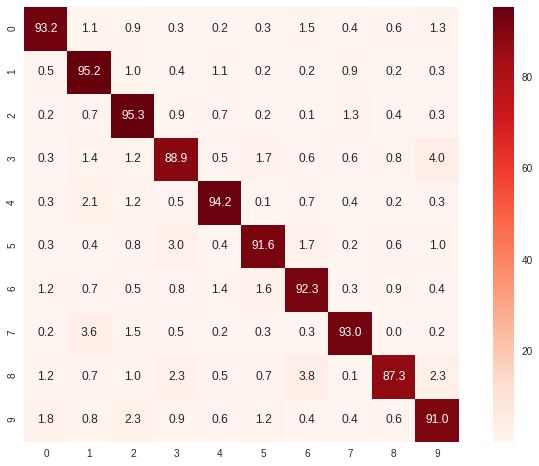

In [0]:
train_mean = np.mean(train_data_GCN, axis=0)
train_std = np.std(train_data_GCN, axis=0)
for i in range(10):
    train_data_GCN_new, train_labels, test_data_GCN, test_labels = train_test_split_10(train_data_GCN, train_labels_t, i)
    train_data_GCN_new = (train_data_GCN_new - train_mean) / train_std
    test_data_GCN_new = (test_data_GCN - train_mean) / train_std
    validation_data_GCN_new = (validation_data_GCN - train_mean) / train_std
    test_pred = train(train_data_GCN_new, train_labels, test_data_GCN_new, test_labels, validation_data_GCN_new,
                      validation_labels_t, i)
    analysis(test_pred,validation_data_GCN_new)

## Experiment

displays results and comparisons for the previously introduced methods. Include runtime, hardware and software specications of the computer that you used for performance evaluations. You are then expected to include meaningful comments on the results of your experiments, and reect on design choices.